# A short overview of LightFM

## By Daniel Crha

### What is LightFM?

LightFM is a library which contains an efficient implementation of the **LightFM model**. It is suitable for both implicit and explicit feedback scenarios, and is well-optimized.

It is especially well suited for cold-start and low density scenarios. The model comes with loss functions which can optimize for precision @ k, or AUC.

It is easy to use correctly, and it works well for its intended scenario, but it's not a multi-tool. It is still just a single model which is not optimal for all scenarios.

Performance is a first-class citizen in LightFM. Model training and evaluation are able to take advantage of multi-threading just by adjusting a function parameter.

The model features some hyperparameters, which can easily be tuned using something like Scikit-Optimize.

### The LightFM model

The LightFM model is hybrid, meaning it is collaborative like matrix factorization, but also content-based.

User and item features have their own latent vectors, and the latent representation of items and users is a combination of the normal matrix factorization latent vector, as well as the content-based latent vector.

### Recommendations with MovieLens

First of all, let's try creating a model for the MovieLens dataset.
We will fit an implicit feedback model for movies with a rating of at least 3 stars.

In [57]:
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k, auc_score

# Load the MovieLens 100k dataset.
# Ratings are treated as positive if the rating is at least 3.0
ml_data = fetch_movielens(min_rating=3.0)

# The k we will be using for all precision @ k measurements
k = 10

First of all, we will define a function which will train our model. It will simply iteratively train the model and every few epochs, it will evaluate how the model is doing.

In [58]:
def train_ml_model(ml_model):
    epoch_count = 500
    epoch_iters = range(5, epoch_count + 1, 5)
    patk_train = []
    patk_test = []
    auc_train = []
    auc_test = []

    # Let's measure how long it takes to train the model as well
    print("Training model...")
    start_time = time.time()

    old_epoch = 0
    for epoch in epoch_iters:
        more = epoch - old_epoch
        ml_model.fit_partial(ml_data["train"], epochs=more, num_threads=8)
        old_epoch = epoch

        patk_train.append(precision_at_k(ml_model, ml_data["train"], k=k).mean())
        patk_test.append(precision_at_k(ml_model, ml_data["test"], k=k).mean())
        auc_train.append(auc_score(ml_model, ml_data['train']).mean())
        auc_test.append(auc_score(ml_model, ml_data['test']).mean())


    end_time = time.time()
    print(f"Training finished! Elapsed time: {end_time - start_time:.2f} s.")
    return epoch_iters, patk_train, patk_test, auc_train, auc_test

Now let's create the model and train it.

We'll use the `WARP` loss function. All we really need to know about it is that it optimizes for precision @ k, as opposed to `BPR` which optimizes for AUC.

Keep this in mind for later, when we examine the results.

In [59]:
# Instantiate and train the model
ml_model = LightFM(loss="warp")
epoch_iters, patk_train, patk_test, auc_train, auc_test = train_ml_model(ml_model)

Training model...
Training finished! Elapsed time: 50.63 s.


Let's check how precision @ k is looking during the course of training for both the training and test datasets.

In [60]:
# Nothing interesting here - just plotting
def plot_patk(epochs, patk, title, k):
    plt.plot(epochs, patk);
    plt.title(title, fontsize=20);
    plt.xlabel('Epochs', fontsize=24);
    plt.ylabel('Precision @ {}'.format(k), fontsize=24);
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);

def plot_auc(epochs, auc, title):
    plt.plot(epochs, auc);
    plt.title(title, fontsize=20);
    plt.xlabel('Epochs', fontsize=24);
    plt.ylabel('AUC', fontsize=24);
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);

def plot_training_evaluation(epoch_iters, patk_train, patk_test, auc_train, auc_test, title):
    plt.figure(figsize=(14, 8), dpi=80)
    plt.suptitle(title, fontsize=30)

    # Plot train on the left
    ax = plt.subplot(2, 2, 1)
    fig = ax.get_figure();
    sns.despine(fig);
    plot_patk(epoch_iters, patk_train, 'Train', k=k)

    # Plot test on the right
    ax = plt.subplot(2, 2, 2)
    fig = ax.get_figure();
    sns.despine(fig);
    plot_patk(epoch_iters, patk_test, 'Test', k=k)

    ax = plt.subplot(2, 2, 3)
    fig = ax.get_figure();
    sns.despine(fig);
    plot_auc(epoch_iters, auc_train, 'Train')

    ax = plt.subplot(2, 2, 4)
    fig = ax.get_figure();
    sns.despine(fig);
    plot_auc(epoch_iters, auc_test, 'Test')

    plt.tight_layout();

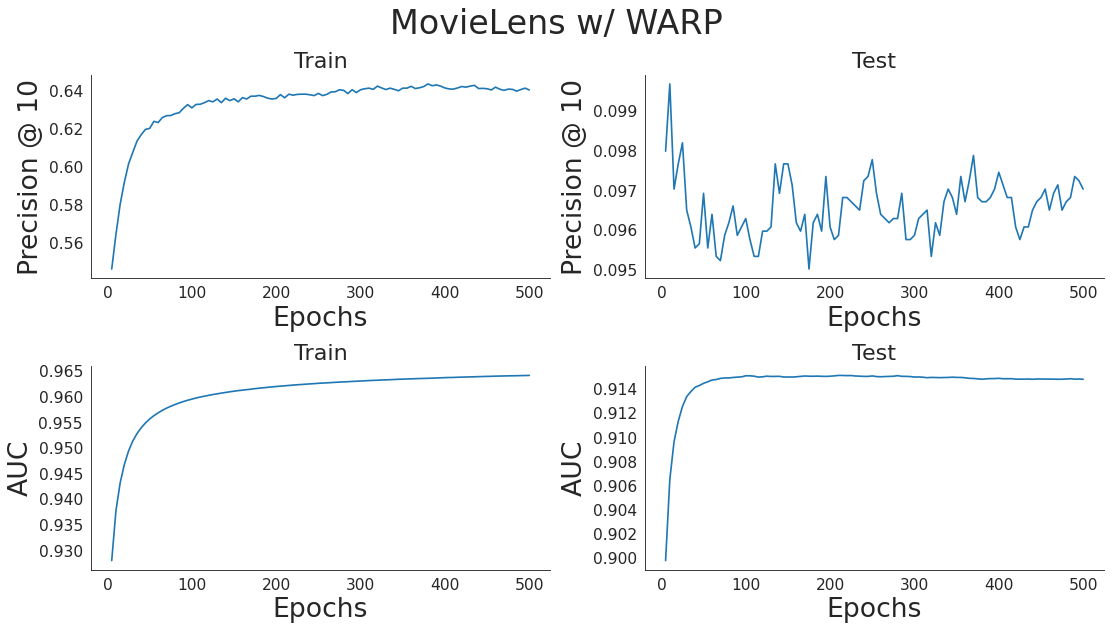

In [61]:
plot_training_evaluation(epoch_iters, patk_train, patk_test, auc_train, auc_test, "MovieLens w/ WARP")

We can see that after about 50 epochs, the model starts overfitting and the test precision is declining.

As far as the speedup is concerned, I tested the effects of threading on training speed.
I evaluated the speedup on 3000 epochs.
With 16 threads, the training takes about 66 seconds.
With only 1 thread, it takes about 95 seconds.
If the dataset was larger, the speedup would probably be larger as well.

Let's also take a look at how we can make an example prediction for a single user.

In [62]:
def make_prediction_for_user(model, user_id):
    _, num_items = ml_data["train"].shape

    liked_movies = ml_data['item_labels'][ml_data['train'].tocsr()[user_id].indices]
    predicted_scores = model.predict(user_id, np.arange(num_items))
    top_items = ml_data['item_labels'][np.argsort(-predicted_scores)]
    
    # Exclude already liked items from the suggestions
    top_items = [item for item in top_items if item not in liked_movies]

    print(f"User {user_id} liked:")
    for liked_movie in liked_movies[:5]:
        print(f"    {liked_movie}")
    
    print(f"Prediction for user {user_id}:")
    for predicted_movie in top_items[:5]:
        print(f"    {predicted_movie}")

make_prediction_for_user(ml_model, 42)

User 42 liked:
    Toy Story (1995)
    Get Shorty (1995)
    Twelve Monkeys (1995)
    Babe (1995)
    Dead Man Walking (1995)
Prediction for user 42:
    Back to the Future (1985)
    Emma (1996)
    Braveheart (1995)
    Phenomenon (1996)
    Much Ado About Nothing (1993)


For comparison, we can check how it looks when we use `BPR` instead of `WARP` as the loss function.
As a reminder, `BPR` optimizes for AUC rather than precision @ k.

If we compare the results for `BPR` with `WARP`, we can clearly see how this is affecting the training.
Selecting the correct loss will depend on the needs of the user.

Training model...
Training finished! Elapsed time: 51.00 s.


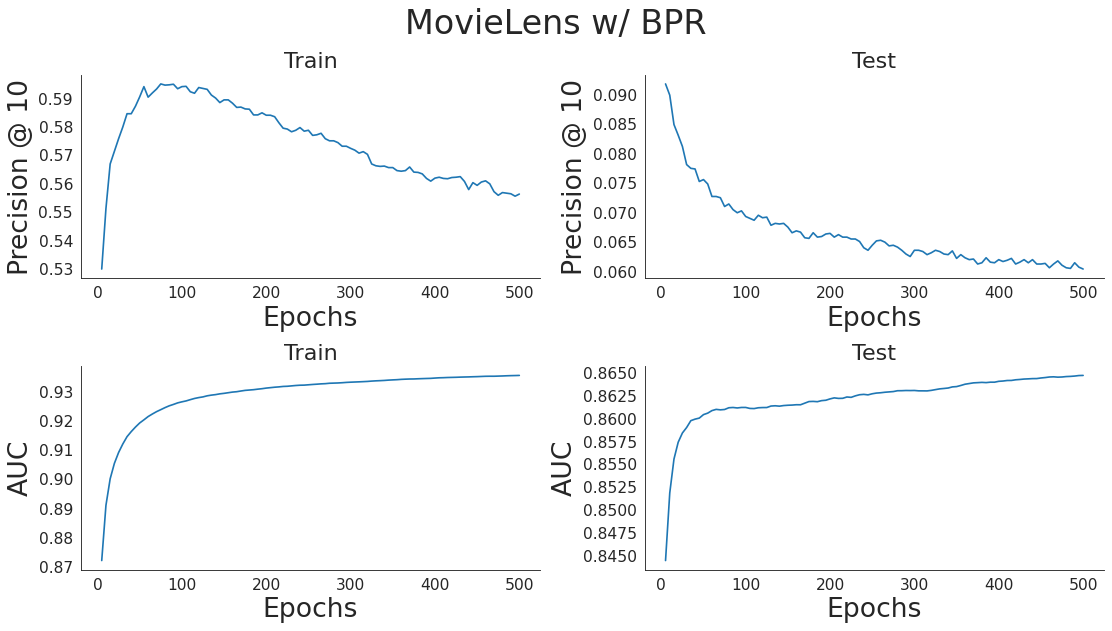

In [63]:
ml_model = LightFM(loss="bpr")
epoch_iters, patk_train, patk_test, auc_train, auc_test = train_ml_model(ml_model)
plot_training_evaluation(epoch_iters, patk_train, patk_test, auc_train, auc_test, "MovieLens w/ BPR")